In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
import PIL
import PIL.Image
import tensorflow as tf
import glob
import pathlib
from pathlib import Path

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD

In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [71]:
# Directory path
train_data_dir = 'chest_xray/chest_xray/train/'
test_data_dir = 'chest_xray/chest_xray/test/'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=600)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=5000)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


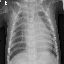

In [72]:
array_to_img(train_images[1])

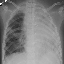

In [73]:
array_to_img(train_images[100])

In [74]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(5000, 64, 64, 3)
(5000, 2)
(600, 64, 64, 3)
(600, 2)


In [41]:
X_train = train_images.reshape(5000,12288)
X_test = test_images.reshape(600,12288)

In [76]:
test_labels.shape

(600, 2)

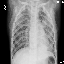

In [90]:
array_to_img(train_images[0])

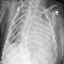

In [91]:
array_to_img(train_images[5])

In [105]:
train_labels

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [103]:
train_labels.T[[1]][0]

array([1., 1., 0., ..., 0., 1., 1.], dtype=float32)

In [107]:
y_train = train_labels.T[[1]][0]
y_test = test_labels.T[[1]][0]

In [111]:
pd.DataFrame(y_train)[0].value_counts()

1.0    3733
0.0    1267
Name: 0, dtype: int64

In [52]:
print(X_train.shape)
print(y_train.shape)

(5000, 12288)
(5000,)


In [53]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [55]:
print(X_train.shape)
print(y_train.shape)

(5000, 12288)
(5000, 10)


In [65]:
X_train /= 255
X_test /= 255

# +++++++++++++++++++++++++++++++++++++

In [7]:
# Reshaping the train images
train_images_unrow = train_images.reshape(5000,-1).T

In [8]:
np.shape(train_images_unrow)

(12288, 5000)

In [9]:
test_images_unrow = test_images.reshape(600,-1).T

In [10]:
np.shape(test_images_unrow)

(12288, 600)

In [11]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [12]:
# changing 2 indice array into singular value for the label
train_labels_final = train_labels.T[[1]]
test_labels_final = test_labels.T[[1]]

In [13]:
print(np.shape(train_labels_final))
print(np.shape(test_labels_final))

(1, 5000)
(1, 600)


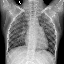

In [14]:
# checking to see if images have correct label 
# not going to be good check
array_to_img(train_images[100])

In [15]:
train_labels_final[:,100]

array([0.], dtype=float32)

### standardizing the image values 
This is done so that instead of a value between 0 and 255 we have a value between 0-1 reprenting how much color is there

In [16]:
train_images_unrow = train_images_unrow/255
test_images_unrow = test_images_unrow/255

In [17]:
pd.DataFrame(train_labels_final.T)[0].value_counts()

1.0    3720
0.0    1280
Name: 0, dtype: int64

### base model testing

In [35]:
batch_size = 8
num_classes = 10
epochs = 3

# forming x and y
X_train = train_images_unrow
X_test = test_images_unrow

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(train_labels_final, num_classes)
y_test = keras.utils.to_categorical(test_labels_final, num_classes)
# y_train = train_labels_final
# y_test = test_labels_final

In [20]:
X_train.shape

(12288, 5000)

In [26]:
X_train = X_train.reshape(5000,12288)

In [28]:
X_train.shape

(5000, 12288)

In [21]:
y_train.shape

(1, 5000, 10)

In [30]:
y_train = y_train[0]

In [31]:
y_train.shape

(5000, 10)

In [58]:
print(X_train.shape)
print(y_train.shape)

(5000, 12288)
(5000, 10)


# +++++++++++++++++++++++++++++++++++++

In [69]:
# model structure
model = Sequential()

# first hidden layer
# 12288 = 64x64x3 = size of image
model.add(Dense(50,activation='relu',input_shape=(12288,)))

# second hidden layer
model.add(Dense(50,activation='relu'))

# output layer
model.add(Dense(num_classes, activation='linear'))

model.summary()

model.compile(loss='kullback_leibler_divergence',
             optimizer=Adam(),
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1)

score = model.evaluate(X_test,y_test,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 50)                614450    
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_17 (Dense)             (None, 10)                510       
Total params: 617,510
Trainable params: 617,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0171 - accuracy: 0.2544
Epoch 2/3
625/625 [==============================] - 1s 2ms/step - loss: -1.1283e-05 - accuracy: 0.2550
Epoch 3/3
625/625 [==============================] - 1s 2ms/step - loss: -1.1283e-05 - accuracy: 0.2550
Test loss: -1.1282666491752025e-05
Test accuracy: 0.3733333349227905
